Name1: Ali Hassan Ali Ahmed ElSharawy - ID1: 19016013

Name2: Ziad Mohamed Abuelkher - ID2: 19015733

Name3: Youssef Magdy Helmy - ID3: 19016937

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import os
from scipy.io import wavfile
# ! pip install pydub
import matplotlib.pyplot as plt
import librosa.display
from pydub import AudioSegment
import IPython
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Activation, BatchNormalization
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


walk through the dataset

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

useful function to treat with data

In [3]:
def read_audio(filepath):
    data, sampling_rate = librosa.load(filepath, sr=None)
    return data, sampling_rate


def plot_audio(filepath):
    data, sampling_rate = read_audio(filepath)
    plt.figure(figsize=(15, 5))
    plt.title('Waveform plot')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    librosa.display.waveshow(data, sr=sampling_rate)
   
def plot_audio_data(data):
    plt.figure(figsize=(15, 5))
    plt.title('Waveform plot')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    librosa.display.waveshow(data)


def play_audio(filepath):
    return IPython.display.Audio(filepath)



read files and sort directory list

In [4]:
path = '/kaggle/input/speech-emotion-recognition-en/Crema'
dir_list = os.listdir(path)
dir_list.sort()
print(dir_list[0:10])

['1001_DFA_ANG_XX.wav', '1001_DFA_DIS_XX.wav', '1001_DFA_FEA_XX.wav', '1001_DFA_HAP_XX.wav', '1001_DFA_NEU_XX.wav', '1001_DFA_SAD_XX.wav', '1001_IEO_ANG_HI.wav', '1001_IEO_ANG_LO.wav', '1001_IEO_ANG_MD.wav', '1001_IEO_DIS_HI.wav']


define emotions in data set

In [5]:
emotions = []
for filename in dir_list:
    emotions.append(filename.split('_')[2])
print(set(emotions))

{'NEU', 'DIS', 'ANG', 'FEA', 'HAP', 'SAD'}


we have 6 different emothions in our dataset:
* ANG : angry
* NEU : neutral
* HAP : happy
* SAD : sad
* DIS : disgust
* FEA : fear

map every emotion to number

In [6]:
dic = {'ANG' : 0, 'NEU' : 1, 'HAP' : 2, 'SAD' : 3, 'DIS' : 4, 'FEA' : 5}

read data from data set and store in lists : data, sample_rate, labels
and extract labels from files name

In [7]:
data = []
sample_rate = []
labels = []
for filename in dir_list:
    record, s = read_audio(path+'/'+filename)
    sample_rate.append(s)
    data.append(record)
    labels.append(dic[filename.split('_')[2]])

get familiar with data and try to chane i to get different samples and look at different features

emotion :  DIS


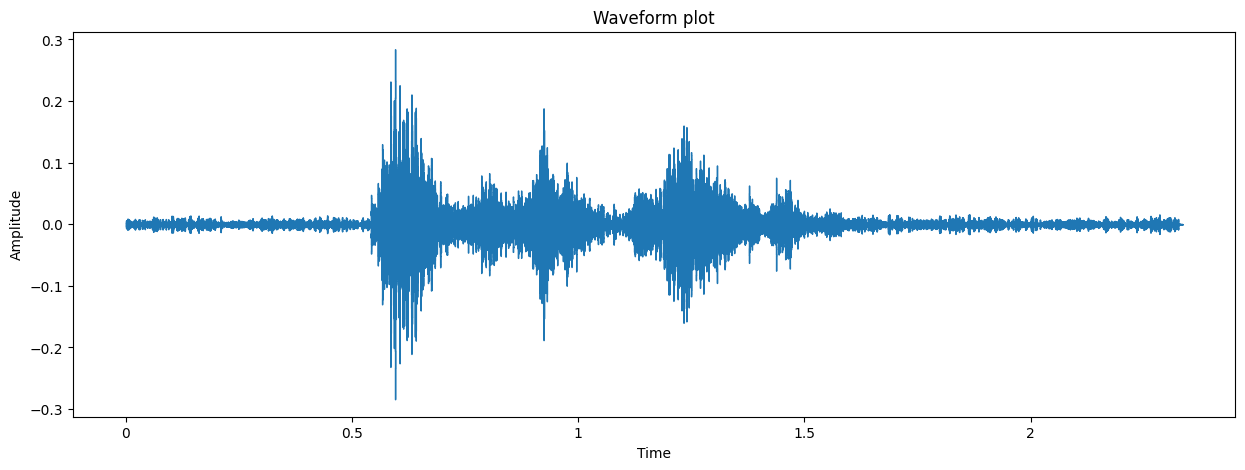

In [8]:
i = 1   # free to change it to display different audio and see wave form
p = path+'/'+dir_list[i]
emotion = dir_list[i].split('_')
print("emotion : ", emotion[2])
plot_audio(p)
IPython.display.Audio(p)

default rms in librose package

(1, 73)
(37371,)


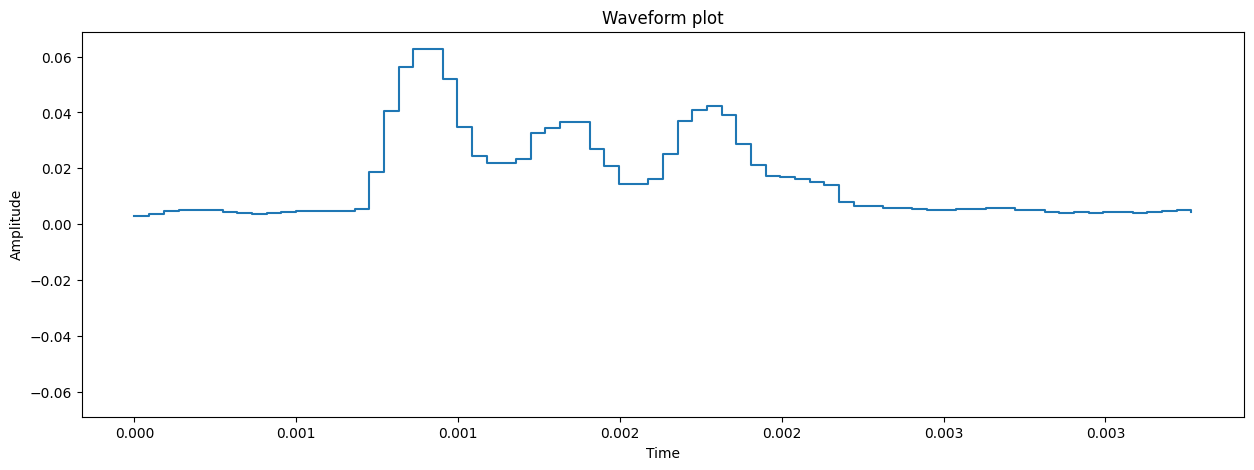

In [9]:
energy = librosa.feature.rms(y=data[i])
plot_audio_data(energy)
print(energy.shape)
print(data[i].shape)

we need to get optimal values of frame_length, hop_length to get features of data good enough for training and don't lose information

(1, 187)


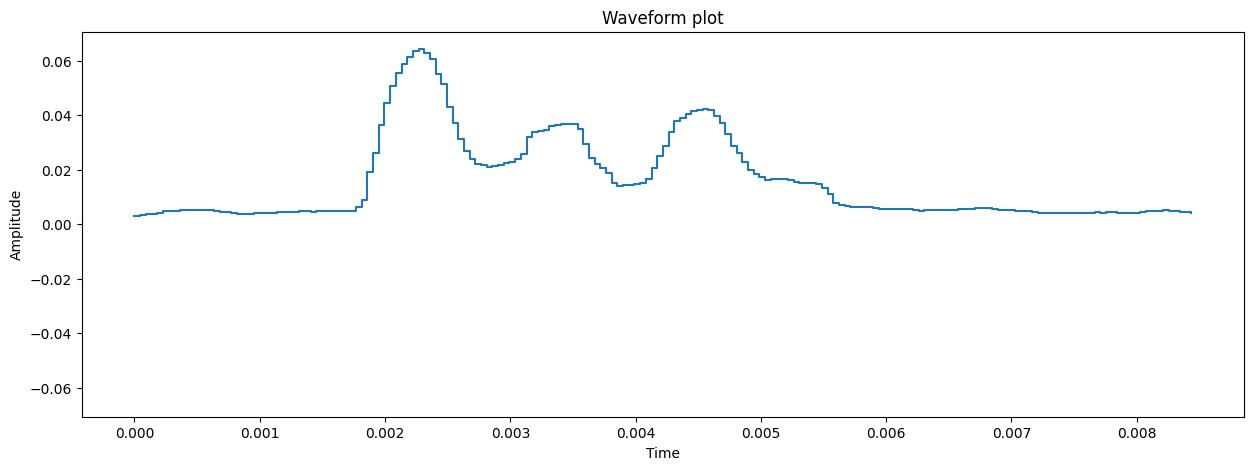

In [10]:
energy = librosa.feature.rms(y=data[i],frame_length=2048,hop_length=200)
plot_audio_data(energy)
print(energy.shape)


default zero crossing rate

(1, 73)


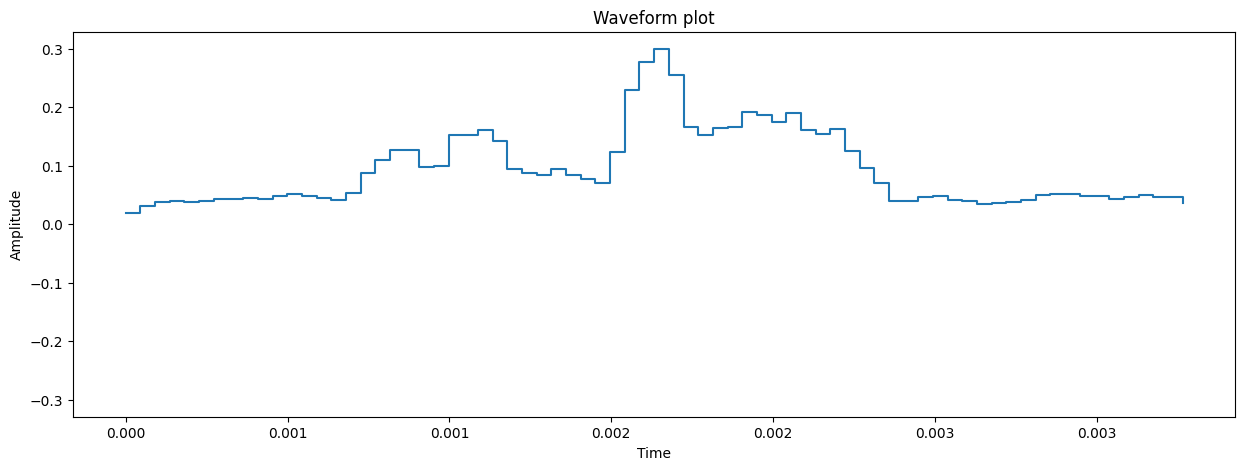

In [11]:
zrc = librosa.feature.zero_crossing_rate(y=data[i])
plot_audio_data(zrc)
print(zrc.shape)


we need to get optimal values of frame_length, hop_length to get features of data good enough for training and don't lose information

(1, 187)


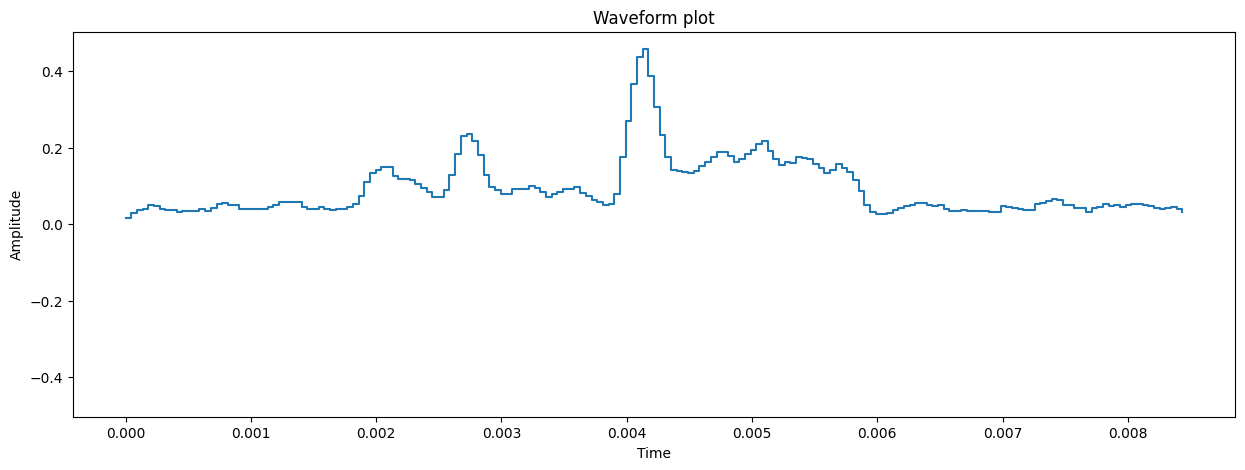

In [12]:
zrc = librosa.feature.zero_crossing_rate(y=data[i],frame_length=1000,hop_length=200)
plot_audio_data(zrc)
print(zrc.shape)

melspectrogram in librosa package

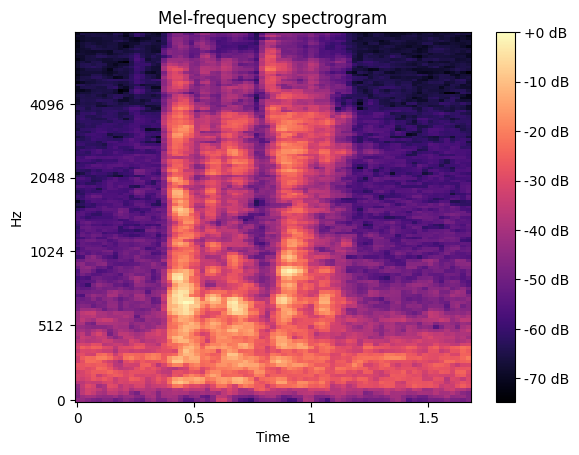

(128, 73)


In [13]:
S = librosa.feature.melspectrogram(y=data[i], n_mels=128, fmax=8000, n_fft=2048, hop_length=512)

# Convert to decibels
S_dB = librosa.power_to_db(S, ref=np.max)

# Display Mel spectrogram
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.show()
print(S_dB.shape)

we need to make all data has same length to be able to train data and do different operation on it

get max data file size to make all files has same lenght by padding
we add zeros from back

In [14]:
max_len = 0
min_len = float('inf')

# loop over the list and update max and min lengths
for arr in data:
    length = len(arr)
    if length > max_len:
        max_len = length
    if length < min_len:
        min_len = length
        
print("Max length:", max_len)
print("Min length:", min_len)

Max length: 80080
Min length: 20287


In [15]:
padded_data = []
for signal in data:
    pad_width = max_len - len(signal)
    padded_signal = np.pad(signal, (0, pad_width), mode='constant')
    padded_data.append(padded_signal)

we store data in padded form so all data has same size 

In [16]:
IPython.display.Audio(padded_data[8], rate = 20000)

In [17]:
IPython.display.Audio(padded_data[13], rate = 20000)

Creare Featues Space from data

In [18]:
data_rms = []
data_zcr = []
data_mel = []

for audio in padded_data:
    data_rms.append(librosa.feature.rms(y=audio,frame_length=2048,hop_length=200))

for audio in padded_data:
    data_zcr.append(librosa.feature.zero_crossing_rate(y=audio,frame_length=1000,hop_length=200))
    
for audio in padded_data:
    S = librosa.feature.melspectrogram(y=audio, n_mels=128, fmax=8000, n_fft=2048, hop_length=512)
    S_dB = librosa.power_to_db(S, ref=np.max)
    data_mel.append(S_dB)
    

split data into trainig, test and validation

In [19]:
data_train_val_rms, data_test_rms, label_train_val_rms, label_test_rms = train_test_split(data_rms, labels, test_size=0.3, random_state=42)
data_train_val_zcr, data_test_zcr, label_train_val_zcr, label_test_zcr = train_test_split(data_zcr, labels, test_size=0.3, random_state=42)
data_train_val_mel, data_test_mel, label_train_val_mel, label_test_mel = train_test_split(data_mel, labels, test_size=0.3, random_state=42)

data_train_rms, data_val_rms, label_train_rms, label_val_rms = train_test_split(data_train_val_rms, label_train_val_rms, test_size=0.05, random_state=42)
data_train_zcr, data_val_zcr, label_train_zcr, label_val_zcr = train_test_split(data_train_val_zcr, label_train_val_zcr, test_size=0.05, random_state=42)
data_train_mel, data_val_mel, label_train_mel, label_val_mel = train_test_split(data_train_val_mel, label_train_val_mel, test_size=0.05, random_state=42)


In [20]:
sample_train_val, sample_test, label_train_val_sample, label_test_sample = train_test_split(sample_rate, labels, test_size=0.3, random_state=42)
sample_train, sample_val, label_train_sample, label_val_sample = train_test_split(sample_train_val, label_train_val_sample, test_size=0.05, random_state=42)


normalize data and convert to numpy array

In [21]:
data_train_rms = np.array(data_train_rms)
data_test_rms = np.array(data_test_rms) 
label_train_rms = np.array(label_train_rms) 
label_test_rms = np.array(label_test_rms)
data_val_rms = np.array(data_val_rms)
label_val_rms = np.array(label_val_rms) 


data_train_zcr = np.array(data_train_zcr)
data_test_zcr = np.array(data_test_zcr) 
label_train_zcr = np.array(label_train_zcr) 
label_test_zcr = np.array(label_test_zcr)
data_val_zcr = np.array(data_val_zcr)
label_val_zcr = np.array(label_val_zcr) 

train_data_mel = np.array(data_train_mel)
data_test_mel = np.array(data_test_mel) 
train_label_mel = np.array(label_train_mel) 
label_test_mel = np.array(label_test_mel)
cv_data_mel = np.array(data_val_mel)
cv_label_mel = np.array(label_val_mel) 

we will use sample rate as feature

In [22]:
sample_train = np.array(sample_train)
sample_val = np.array(sample_val) 
label_train_sample = np.array(label_train_sample) 
label_val_sample = np.array(label_val_sample)

sample_test = np.array(sample_test)
label_test_sample = np.array(label_test_sample)

In [23]:
print(sample_train.shape)
print(sample_val.shape)
print(sample_test.shape)

(4948,)
(261,)
(2233,)


normalize data

normalize rms feature

In [24]:
rms_train_reshape = data_train_rms.reshape(data_train_rms.shape[0],data_train_rms.shape[2])
rms_val_reshape = data_val_rms.reshape(data_val_rms.shape[0],data_val_rms.shape[2])
rms_test_reshape = data_test_rms.reshape(data_test_rms.shape[0],data_test_rms.shape[2])

scaler_rms = StandardScaler()
data_train_rms_norm = scaler_rms.fit_transform(rms_train_reshape)
data_train_rms_norm = scaler_rms.transform(rms_train_reshape)
data_test_rms_norm = scaler_rms.transform(rms_test_reshape)
data_val_rms_norm = scaler_rms.transform(rms_val_reshape)


In [25]:
print(data_train_rms_norm.shape)
print(data_test_rms_norm.shape)
print(data_val_rms_norm.shape)

(4948, 401)
(2233, 401)
(261, 401)


In [26]:
data_train_rms_norm = data_train_rms_norm.reshape((data_train_rms_norm.shape[0],data_train_rms_norm.shape[1],1))
data_test_rms_norm = data_test_rms_norm.reshape((data_test_rms_norm.shape[0],data_test_rms_norm.shape[1],1))
data_val_rms_norm = data_val_rms_norm.reshape((data_val_rms_norm.shape[0],data_val_rms_norm.shape[1],1))

normalize zcr feature

In [27]:
zcr_train_reshape = data_train_zcr.reshape(data_train_zcr.shape[0],data_train_zcr.shape[2])
zcr_val_reshape = data_val_zcr.reshape(data_val_zcr.shape[0],data_val_zcr.shape[2])
zcr_test_reshape = data_test_zcr.reshape(data_test_zcr.shape[0],data_test_zcr.shape[2])

scaler_zcr = StandardScaler()
data_train_zcr_norm = scaler_zcr.fit_transform(zcr_train_reshape)
data_train_zcr_norm = scaler_zcr.transform(zcr_train_reshape)
data_test_zcr_norm = scaler_zcr.transform(zcr_test_reshape)
data_val_zcr_norm = scaler_zcr.transform(zcr_val_reshape)

In [28]:
print(data_train_zcr_norm.shape)
print(data_test_zcr_norm.shape)
print(data_val_zcr_norm.shape)

(4948, 401)
(2233, 401)
(261, 401)


In [29]:
data_train_zcr_norm = data_train_zcr_norm.reshape((data_train_zcr_norm.shape[0],data_train_zcr_norm.shape[1],1))
data_test_zcr_norm = data_test_zcr_norm.reshape((data_test_zcr_norm.shape[0],data_test_zcr_norm.shape[1],1))
data_val_zcr_norm = data_val_zcr_norm.reshape((data_val_zcr_norm.shape[0],data_val_zcr_norm.shape[1],1))

In [30]:
print(data_train_zcr_norm.shape)
print(data_test_zcr_norm.shape)
print(data_val_zcr_norm.shape)

(4948, 401, 1)
(2233, 401, 1)
(261, 401, 1)


normalize mel spectogram feature

In [33]:
mel_train_reshape = train_data_mel.reshape(train_data_mel.shape[0],train_data_mel.shape[1]*train_data_mel.shape[2])
mel_cv_reshape = cv_data_mel.reshape(cv_data_mel.shape[0],cv_data_mel.shape[1]*cv_data_mel.shape[2])
mel_test_reshape = data_test_mel.reshape(data_test_mel.shape[0],data_test_mel.shape[1]*data_test_mel.shape[2])
print(cv_data_mel.shape)

(261, 128, 157)


In [34]:
scaler_mel = StandardScaler()
data_train_mel_norm = scaler_mel.fit_transform(mel_train_reshape)
data_train_mel_norm = scaler_mel.transform(mel_train_reshape)
data_test_mel_norm = scaler_mel.transform(mel_test_reshape)
data_cv_mel_norm = scaler_mel.transform(mel_cv_reshape)

In [35]:
print(data_train_mel_norm.shape)
print(data_test_mel_norm.shape)
print(data_cv_mel_norm.shape)
data_train_mel_norm = data_train_mel_norm.reshape((data_train_mel_norm.shape[0],train_data_mel.shape[1],train_data_mel.shape[2]))
data_test_mel_norm = data_test_mel_norm.reshape((data_test_mel_norm.shape[0],data_test_mel.shape[1], data_test_mel.shape[2]))
data_cv_mel_norm = data_cv_mel_norm.reshape((data_cv_mel_norm.shape[0],cv_data_mel.shape[1],cv_data_mel.shape[2]))
print(data_train_mel_norm.shape)
print(data_test_mel_norm.shape)
print(data_cv_mel_norm.shape)

(4948, 20096)
(2233, 20096)
(261, 20096)
(4948, 128, 157)
(2233, 128, 157)
(261, 128, 157)


concatinate data to get time domain feature

In [36]:
train_time = np.concatenate((data_train_rms_norm, data_train_zcr_norm), axis = -1)
val_time = np.concatenate((data_val_rms_norm, data_val_zcr_norm), axis = -1)
test_time = np.concatenate((data_test_rms_norm, data_test_zcr_norm), axis = -1)

In [37]:
train_time = train_time.reshape(train_time.shape[0], -1, 1)
val_time = val_time.reshape(val_time.shape[0], -1, 1)
test_time = test_time.reshape(test_time.shape[0], -1, 1)

add sample rate as second channel

In [ ]:
# sample_train = sample_train.reshape(-1,1,1)
# sample_test = sample_test.reshape(-1,1,1)
# sample_val = sample_val.reshape(-1,1,1)

In [ ]:
# print(sample_train.shape)
# print(train_time.shape)

In [ ]:

# train_time = np.concatenate((train_time, sample_train), axis = 1)
# val_time = np.concatenate((val_time, sample_val), axis = 1)
# test_time = np.concatenate((test_time, sample_test), axis = 1)

In [39]:
# print(train_time.shape)
# print(label_time_train.shape)

RMSE model

build model

In [40]:
model_time = Sequential()
alpha = 0.000001
model_time.add(Conv1D(64, 16, padding='same',input_shape=(train_time.shape[1],1))) 

model_time.add(LeakyReLU(alpha=alpha))
model_time.add(BatchNormalization())

model_time.add(Conv1D(64, 16, padding='same'))

model_time.add(LeakyReLU(alpha=alpha))
model_time.add(Conv1D(64, 16, padding='same'))

model_time.add(LeakyReLU(alpha=alpha))

model_time.add(Conv1D(64, 16, padding='same'))

model_time.add(LeakyReLU(alpha=alpha))
model_time.add(Conv1D(64, 16, padding='same'))

model_time.add(LeakyReLU(alpha=alpha))

model_time.add(MaxPooling1D(pool_size=(8)))
model_time.add(Conv1D(64, 16, padding='same'))
model_time.add(LeakyReLU(alpha=alpha))

model_time.add(Conv1D(64, 8, padding='same'))
model_time.add(LeakyReLU(alpha=alpha))

model_time.add(BatchNormalization())
model_time.add(Conv1D(128, 8, padding='same'))
model_time.add(LeakyReLU(alpha=alpha))
model_time.add(Conv1D(128, 8, padding='same'))
model_time.add(LeakyReLU(alpha=alpha))

model_time.add(Dropout(0.2))
model_time.add(Conv1D(256, 8, padding='same'))
model_time.add(LeakyReLU(alpha=alpha))

model_time.add(MaxPooling1D(pool_size=(8)))
model_time.add(BatchNormalization())
model_time.add(Conv1D(256, 8, padding='same'))
model_time.add(LeakyReLU(alpha=alpha))

model_time.add(Conv1D(256, 4, padding='same'))
model_time.add(LeakyReLU(alpha=alpha))

model_time.add(Conv1D(512, 4, padding='same'))
model_time.add(LeakyReLU(alpha=alpha))
model_time.add(Conv1D(512, 4, padding='same'))
model_time.add(LeakyReLU(alpha=alpha))

model_time.add(Flatten())
model_time.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model_time.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model_time.add(Dense(6, activation='softmax'))
model_time.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 802, 64)           1088      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 802, 64)           0         
                                                                 
 batch_normalization (BatchN  (None, 802, 64)          256       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 802, 64)           65600     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 802, 64)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 802, 64)           65600     
                                                        

concatinate label data

In [41]:
from keras.utils import to_categorical

label_time_train = to_categorical(label_train_rms, 6)
label_time_test = to_categorical(label_test_rms, 6)
label_time_val = to_categorical(label_val_rms, 6)

In [42]:
print(train_time.shape)
print(val_time.shape)

(4948, 802, 1)
(261, 802, 1)


In [44]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=5)

model_time.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_history=model_time.fit(train_time, label_time_train, batch_size=32, epochs=100,
                        validation_data=(val_time, label_time_val), callbacks=[early_stopping_callback])

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model_history=model.fit(train_time, label_time_train, batch_size=32, epochs=20,
#                         validation_data=(val_time, label_time_val))


Epoch 1/100
155/155 [==============================] - 18s 31ms/step - loss: 2.3396 - accuracy: 0.3333 - val_loss: 1.9958 - val_accuracy: 0.2605
Epoch 2/100
155/155 [==============================] - 4s 23ms/step - loss: 1.6364 - accuracy: 0.3824 - val_loss: 1.6556 - val_accuracy: 0.3678
Epoch 3/100
155/155 [==============================] - 4s 24ms/step - loss: 1.5467 - accuracy: 0.4131 - val_loss: 1.5220 - val_accuracy: 0.3908
Epoch 4/100
155/155 [==============================] - 4s 24ms/step - loss: 1.4974 - accuracy: 0.4258 - val_loss: 1.4430 - val_accuracy: 0.4444
Epoch 5/100
155/155 [==============================] - 4s 24ms/step - loss: 1.4798 - accuracy: 0.4274 - val_loss: 1.4704 - val_accuracy: 0.4521
Epoch 6/100
155/155 [==============================] - 4s 24ms/step - loss: 1.4560 - accuracy: 0.4323 - val_loss: 1.4050 - val_accuracy: 0.4598
Epoch 7/100
155/155 [==============================] - 4s 24ms/step - loss: 1.4322 - accuracy: 0.4351 - val_loss: 1.5785 - val_accuracy

evalute model performance

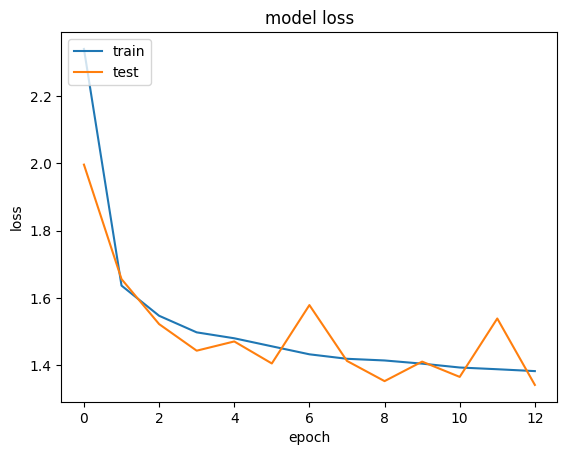

In [45]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
pred = model_time.predict(test_time)

70/70 [==============================] - 1s 9ms/step


In [48]:
print(pred)

[[6.54770017e-01 6.02504704e-04 1.72963589e-01 4.95522516e-04
  2.90141385e-02 1.42154217e-01]
 [1.96295306e-02 2.63427854e-01 1.15780577e-01 2.98779100e-01
  1.39243722e-01 1.63139209e-01]
 [3.87055129e-02 1.47476450e-01 1.86895311e-01 1.10940345e-01
  2.53588766e-01 2.62393653e-01]
 ...
 [1.71514899e-02 3.19855750e-01 1.08466461e-01 2.87581831e-01
  1.34053141e-01 1.32891387e-01]
 [2.88596991e-02 3.50182027e-01 1.53114676e-01 1.41299054e-01
  1.36858702e-01 1.89685851e-01]
 [7.56240590e-03 5.93177676e-02 5.88369817e-02 3.32595825e-01
  2.77759373e-01 2.63927639e-01]]


In [50]:
pred_time = np.argmax(pred, axis=1)

print(pred_time)
label_time_test_time = np.argmax(label_time_test, axis=1)
print(label_time_test_time)

[0 3 5 ... 1 1 3]
[5 3 4 ... 3 1 4]


In [51]:
from sklearn.metrics import f1_score

f1 = f1_score(label_time_test_time, pred_time, average='weighted')
print("f score measure : ", f1)

f score measure :  0.4329533463971103


In [73]:
print(label_time_test)

[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]


In [53]:
score = model_time.evaluate(test_time, label_time_test, verbose=0)
print("accuracy measure : ",score[1])
print("loss measure : ",score[0])

accuracy measure :  0.45991939306259155
loss measure :  1.3897926807403564


========================================================================================================

mel spectrogram mdel

In [59]:
model_mel = Sequential()
model_mel.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(data_train_mel_norm.shape[1],data_train_mel_norm.shape[2],1)))
model_mel.add(MaxPooling2D(pool_size=(2, 2)))
model_mel.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_mel.add(MaxPooling2D(pool_size=(2, 2)))
model_mel.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_mel.add(MaxPooling2D(pool_size=(2, 2)))
model_mel.add(Flatten())
model_mel.add(Dense(128, activation='relu'))
model_mel.add(Dense(64, activation='relu'))
model_mel.add(Dense(6, activation='softmax'))
model_mel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 155, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 77, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 75, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 35, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 17, 128)     

convert to hot code label

In [60]:
from keras.utils import to_categorical
cat_train_label = to_categorical(train_label_mel, 6)
cat_cv_label = to_categorical(cv_label_mel)
print(cat_train_label.shape)
print(cat_cv_label.shape)

(4948, 6)
(261, 6)


train model

In [61]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=10)
model_mel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_history=model_mel.fit(data_train_mel_norm, cat_train_label, batch_size=32, epochs=100, validation_data=(data_cv_mel_norm, cat_cv_label),callbacks=[early_stopping_callback])

Epoch 1/100
155/155 [==============================] - 4s 15ms/step - loss: 1.5282 - accuracy: 0.3771 - val_loss: 1.4126 - val_accuracy: 0.4789
Epoch 2/100
155/155 [==============================] - 2s 15ms/step - loss: 1.3358 - accuracy: 0.4733 - val_loss: 1.3421 - val_accuracy: 0.5057
Epoch 3/100
155/155 [==============================] - 2s 13ms/step - loss: 1.1980 - accuracy: 0.5325 - val_loss: 1.1746 - val_accuracy: 0.5517
Epoch 4/100
155/155 [==============================] - 2s 13ms/step - loss: 1.0401 - accuracy: 0.6051 - val_loss: 1.2360 - val_accuracy: 0.5249
Epoch 5/100
155/155 [==============================] - 2s 13ms/step - loss: 0.8521 - accuracy: 0.6750 - val_loss: 1.1646 - val_accuracy: 0.5939
Epoch 6/100
155/155 [==============================] - 2s 13ms/step - loss: 0.6420 - accuracy: 0.7565 - val_loss: 1.4382 - val_accuracy: 0.5096
Epoch 7/100
155/155 [==============================] - 2s 13ms/step - loss: 0.4157 - accuracy: 0.8486 - val_loss: 1.5988 - val_accuracy:

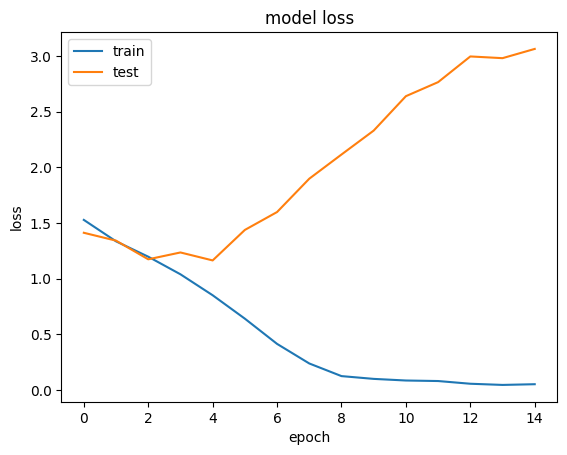

In [62]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

evalute model performance

In [64]:
pred = model_mel.predict(data_test_mel_norm)
print(pred)

70/70 [==============================] - 0s 6ms/step
[[9.99955535e-01 1.13819287e-22 3.78458826e-05 1.54699739e-13
  2.75636565e-16 6.62365983e-06]
 [1.80216812e-04 5.32235026e-01 8.40027269e-07 4.66214150e-01
  2.08244001e-05 1.34900946e-03]
 [7.17388320e-05 4.05109931e-05 5.35217300e-03 4.60997717e-06
  1.20479278e-01 8.74051690e-01]
 ...
 [2.83548841e-04 3.98541195e-03 8.54643166e-01 1.40758500e-01
  2.91849894e-04 3.74945193e-05]
 [1.21240455e-05 9.94802952e-01 1.22962518e-07 5.18436916e-03
  3.95581793e-07 8.43647499e-08]
 [2.14086685e-04 7.08788320e-06 3.71561535e-02 1.01014669e-03
  8.66688728e-01 9.49238539e-02]]


In [67]:
pred_mel = np.argmax(pred, axis=1)

print(pred_mel)
print(label_test_mel)

[0 1 5 ... 2 1 4]
[5 3 4 ... 3 1 4]


In [69]:
f1 = f1_score(label_test_mel, pred_mel, average='weighted')
print("f score measure : ", f1)

f score measure :  0.5342704134448267


In [74]:
print(to_categorical(label_test_mel, 6))

[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]


In [75]:
score = model_mel.evaluate(data_test_mel_norm, to_categorical(label_test_mel), verbose=0)
print("accuracy measure : ",score[1])
print("loss measure : ",score[0])

accuracy measure :  0.5396327972412109
loss measure :  3.205275058746338


========================================================================================================

confusion matrix

In [76]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(actual, predicted):
    # create confusion matrix using sklearn's confusion_matrix function
    cm = confusion_matrix(actual, predicted)

    print(cm)
    return cm

def confusing_classes(conf_matrix, threshold, categories):
    pairs_numbers = []

    for i in range(len(conf_matrix)):
        for j in range(len(conf_matrix[i])):
            if i != j:
                misclassifications = conf_matrix[i][j] + conf_matrix[j][i]

                if misclassifications > threshold:
                    pairs_numbers.append(((categories[i], categories[j]), misclassifications))

    pairs_numbers.sort(key=lambda x: x[1], reverse=True)

    return pairs_numbers

def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

confusion matrix for time feature

[[291   6  41   3   9   9]
 [  7 144  62  65  33  42]
 [ 97  45 150  24  22  40]
 [  2  31  12 286  23  32]
 [ 54  32  43 123  72  62]
 [ 60  31  61 108  27  84]]


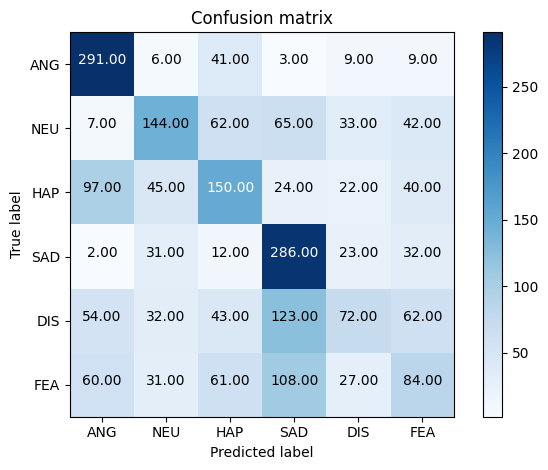

Confused classes with more than 100 misclassifications are:
Classes (SAD , DIS) --> 146
Classes (SAD , FEA) --> 140
Classes (ANG , HAP) --> 138
Classes (NEU , HAP) --> 107
Classes (HAP , FEA) --> 101


In [77]:
conf_matrix = get_confusion_matrix(label_time_test_time, pred_time)
classes = [0, 1, 2, 3, 4, 5]

reverse_dic = {value: key for key, value in dic.items()}
category_list = [reverse_dic[value] for value in classes]
# print(category_list)

plot_confusion_matrix(conf_matrix, category_list)
threshold=100
confused_classes = confusing_classes(conf_matrix, threshold, category_list)
print(f"Confused classes with more than {threshold} misclassifications are:")
i=0
for pair, value in confused_classes:
    if(i%2==0):
        print(f"Classes ({pair[0]} , {pair[1]}) --> {value}")
    i+=1

confusion matrix for mel spectrogram

conf_matrix = get_confusion_matrix(label_test_mel, pred_mel)
classes = [0, 1, 2, 3, 4, 5]

reverse_dic = {value: key for key, value in dic.items()}
category_list = [reverse_dic[value] for value in classes]
# print(category_list)

plot_confusion_matrix(conf_matrix, category_list)
threshold=100
confused_classes = confusing_classes(conf_matrix, threshold, category_list)
print(f"Confused classes with more than {threshold} misclassifications are:")
i=0
for pair, value in confused_classes:
    if(i%2==0):
        print(f"Classes ({pair[0]} , {pair[1]}) --> {value}")
    i+=1